# Matrix Factorisation - Linear with Bias

This is the classical collaborative filtering model with addition of bias

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
%matplotlib inline

### Prepare the data

In [ ]:
df_ratings = pd.read_csv("/content/ratings.csv")
df_items = pd.read_csv("/content/items.csv")

In [ ]:
pip install sklearn

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
def encode_user_item(df, user_col, item_col, rating_col, time_col):
    """Function to encode users and items
    
    Params:     
        df (pd.DataFrame): Pandas data frame to be used.
        user_col (string): Name of the user column.
        item_col (string): Name of the item column.
        rating_col (string): Name of the rating column.
        timestamp_col (string): Name of the timestamp column.
    
    Returns: 
        encoded_df (pd.DataFrame): Modifed dataframe with the users and items index
    """
    
    encoded_df = df.copy()
    
    user_encoder = LabelEncoder()
    user_encoder.fit(encoded_df[user_col].values)
    n_users = len(user_encoder.classes_)
    
    item_encoder = LabelEncoder()
    item_encoder.fit(encoded_df[item_col].values)
    n_items = len(item_encoder.classes_)

    encoded_df["USER"] = user_encoder.transform(encoded_df[user_col])
    encoded_df["ITEM"] = item_encoder.transform(encoded_df[item_col])
    
    encoded_df.rename({rating_col: "RATING", time_col: "TIMESTAMP"}, axis=1, inplace=True)
    
    print("Number of users: ", n_users)
    print("Number of items: ", n_items)
    
    return encoded_df, user_encoder, item_encoder

In [ ]:
# Data Encoding
DATA, user_encoder, item_encoder = encode_user_item(df_ratings, "user_id", "movie_id", "rating", "unix_timestamp")

Number of users:  943
Number of items:  1682


In [ ]:
n_users = DATA.USER.nunique()
n_items = DATA.ITEM.nunique()
n_users, n_items

(943, 1682)

In [ ]:
max_rating = DATA.RATING.max()
min_rating = DATA.RATING.min()
min_rating, max_rating

(1, 5)

In [ ]:
def user_split (df, ratios, chrono=False):
    
    """Function to split pandas DataFrame into train, validation and test (by user in chronological order)
    
    Params:     
        df (pd.DataFrame): Pandas data frame to be split.
        ratios (list of floats): list of ratios for split. The ratios have to sum to 1.
        chrono (boolean): whether to sort in chronological order or not
    
    Returns: 
        list: List of pd.DataFrame split by the given specifications.
    """
    seed = 42                  # Set random seed
    samples = df.shape[0]      # Number of samples
    col_time = "TIMESTAMP"
    col_user = "USER"
    
    # Split by each group and aggregate splits together.
    splits = []

    # Sort in chronological order, the split by users
    if chrono == True:
        df_grouped = df.sort_values(col_time).groupby(col_user)
    else:
        df_grouped = df.groupby(col_user)

        
    
    for name, group in df_grouped:
        group_splits = random_split(df_grouped.get_group(name), ratios, shuffle=False)
        
        # Concatenate the list of split dataframes.
        concat_group_splits = pd.concat(group_splits)
        splits.append(concat_group_splits)
    
    # Concatenate splits for all the groups together.
    splits_all = pd.concat(splits)

    # Take split by split_index
    splits_list = [ splits_all[splits_all["split_index"] == x] for x in range(len(ratios))]

    return splits_list

In [ ]:
def random_split (df, ratios, shuffle=False):
    
    """Function to split pandas DataFrame into train, validation and test
    
    Params:     
        df (pd.DataFrame): Pandas data frame to be split.
        ratios (list of floats): list of ratios for split. The ratios have to sum to 1.
    
    Returns: 
        list: List of pd.DataFrame split by the given specifications.
    """
    seed = 42                  # Set random seed
    if shuffle == True:
        df = df.sample(frac=1)     # Shuffle the data
    samples = df.shape[0]      # Number of samples
    
    # Converts [0.7, 0.2, 0.1] to [0.7, 0.9]
    split_ratio = np.cumsum(ratios).tolist()[:-1] # Get split index
    
    # Get the rounded integer split index
    split_index = [round(x * samples) for x in split_ratio]
    
    # split the data
    splits = np.split(df, split_index)
    
    # Add split index (this makes splitting by group more efficient).
    for i in range(len(ratios)):
        splits[i]["split_index"] = i

    return splits

In [ ]:
# Data Splitting
train, test = user_split(DATA, [0.8, 0.2])

In [ ]:
train.shape, test.shape

((80000, 7), (20000, 7))

## Explicit Matrix Factorisation 

This is a model with User and Item Embedding Dot Product + adjustment for user bias

In [ ]:
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dot, Add, Lambda, Activation, Reshape
from keras.regularizers import l2
from keras.constraints import non_neg
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot

### Build the Model

In [ ]:
def Explicit_MF_Bias(n_users, n_items, n_factors):
    
    # Item Layer
    item_input = Input(shape=[1], name='Item')
    item_embedding = Embedding(n_items, n_factors, embeddings_regularizer=l2(1e-6), name='ItemEmbedding')(item_input)
    item_vec = Flatten(name='FlattenItemE')(item_embedding)
    
    # Item Bias
    item_bias = Embedding(n_items, 1, embeddings_regularizer=l2(1e-6), name='ItemBias')(item_input)
    item_bias_vec = Flatten(name='FlattenItemBiasE')(item_bias)

    # User Layer
    user_input = Input(shape=[1], name='User')
    user_embedding = Embedding(n_users, n_factors, embeddings_regularizer=l2(1e-6), name='UserEmbedding')(user_input)
    user_vec = Flatten(name='FlattenUserE')(user_embedding)
    
    # User Bias
    user_bias = Embedding(n_users, 1, embeddings_regularizer=l2(1e-6), name='UserBias')(user_input)
    user_bias_vec = Flatten(name='FlattenUserBiasE')(user_bias)

    # Dot Product of Item and User & then Add Bias
    DotProduct = Dot(axes=1, name='DotProduct')([item_vec, user_vec])
    AddBias = Add(name="AddBias")([DotProduct, item_bias_vec, user_bias_vec])
    
    # Scaling for each user
    y = Activation('sigmoid')(AddBias)
    rating_output = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(y)
    
    # Model Creation
    model = Model([user_input, item_input], rating_output)
    
    # Compile Model
    model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001))
    
    return model

In [ ]:
n_factors = 50
model = Explicit_MF_Bias(n_users, n_items, n_factors)

In [ ]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
User (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
ItemEmbedding (Embedding)       (None, 1, 50)        84100       Item[0][0]                       
__________________________________________________________________________________________________
UserEmbedding (Embedding)       (None, 1, 50)        47150       User[0][0]                       
_______________________________________________________________________________________

### Train the Model

In [ ]:
%%time
output = model.fit([train.USER, train.ITEM], train.RATING, batch_size=128,
                                  epochs=5, verbose=1, 
                   validation_data=([test.USER, test.ITEM], test.RATING))

Epoch 1/5
625/625 [==============================] - 2s 2ms/step - loss: 1.3594 - val_loss: 1.1534
Epoch 2/5
625/625 [==============================] - 2s 3ms/step - loss: 0.9584 - val_loss: 0.9242
Epoch 3/5
625/625 [==============================] - 2s 3ms/step - loss: 0.8054 - val_loss: 0.8696
Epoch 4/5
625/625 [==============================] - 2s 3ms/step - loss: 0.7104 - val_loss: 0.8473
Epoch 5/5
625/625 [==============================] - 2s 2ms/step - loss: 0.6296 - val_loss: 0.8408
CPU times: user 11 s, sys: 1.02 s, total: 12 s
Wall time: 8.82 s


In [ ]:
import altair as alt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from keras.preprocessing.image import ImageDataGenerator
        
# Visualise the metrics from the model
def metrics(history):
    df = pd.DataFrame(history)
    df.reset_index()
    df["batch"] = df.index + 1
    df = df.melt("batch", var_name="name")
    df["val"] = df.name.str.startswith("val")
    df["type"] = df["val"]
    df["metrics"] = df["val"]
    df.loc[df.val == False, "type"] = "training"
    df.loc[df.val == True, "type"] = "validation"
    df.loc[df.val == False, "metrics"] = df.name
    df.loc[df.val == True, "metrics"] = df.name.str.split("val_", expand=True)[1]
    df = df.drop(["name", "val"], axis=1)
    
    base = alt.Chart().encode(
        x = "batch:Q",
        y = "value:Q",
        color = "type"
    ).properties(width = 300, height = 300)

    layers = base.mark_circle(size = 50).encode(tooltip = ["batch", "value"]) + base.mark_line()
    chart = layers.facet(column='metrics:N', data=df).resolve_scale(y='independent')    
    
    return chart

In [ ]:
metrics(output.history)

alt.FacetChart(...)

### Score the Model

In [ ]:
score = model.evaluate([test.USER, test.ITEM], test.RATING, verbose=1)
score

625/625 [==============================] - 1s 2ms/step - loss: 0.8408


0.8407534956932068

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
print(mean_absolute_error(test.RATING, model.predict([test.USER, test.ITEM])))
print(mean_squared_error(test.RATING, model.predict([test.USER, test.ITEM])))

0.7240614729106426
0.8375123005825557


### Prediction & recommendation

In [ ]:
def get_embedding(model, name):
    embedding = model.get_layer(name = name).get_weights()[0]
    return embedding

def get_predictions(model, data):
    """
    Get predictions for all user-item combinations
    
    Params:
        data (pandas.DataFrame): DataFrame of entire rating data
        model (Keras.model): Trained keras model
        
    Returns:
        pd.DataFrame: DataFrame of rating predictions for each user and each item
        
    """
    # Create the crossjoin for user-item
    user_item = user_item_crossjoin(data)
    
    # Score for every user-item combination
    user_item["RATING_PRED"] = model.predict([user_item.USER, user_item.ITEM])
    
    return user_item


def user_item_crossjoin(df):
    """
    Get cross-join of all users and items
    
    Args:
        df (pd.DataFrame): Source dataframe.

    Returns:
        pd.DataFrame: Dataframe with crossjoins
    
    """
    
    crossjoin_list = []
    for user in df.USER.unique():
        for item in df.ITEM.unique():
            crossjoin_list.append([user, item])

    cross_join_df = pd.DataFrame(data=crossjoin_list, columns=["USER", "ITEM"])
    
    return cross_join_df
    

def filter_by(df, filter_by_df, filter_by_cols):
    """From the input DataFrame (df), remove the records whose target column (filter_by_cols) values are
    exist in the filter-by DataFrame (filter_by_df)

    Args:
        df (pd.DataFrame): Source dataframe.
        filter_by_df (pd.DataFrame): Filter dataframe.
        filter_by_cols (iterable of str): Filter columns.

    Returns:
        pd.DataFrame: Dataframe filtered by filter_by_df on filter_by_cols
    """

    return df.loc[
        ~df.set_index(filter_by_cols).index.isin(
            filter_by_df.set_index(filter_by_cols).index
        )
    ]


def get_top_k_items(df, col_user, col_rating, k=10):
    """Get the top k items for each user.

    Params:
        dataframe (pandas.DataFrame): DataFrame of rating data
        col_user (str): column name for user
        col_rating (str): column name for rating
        k (int): number of items for each user

    Returns:
        pd.DataFrame: DataFrame of top k items for each user, sorted by `col_user` and `rank`
    """
    # Sort dataframe by col_user and (top k) col_rating
    top_k_items = (
        df.groupby(col_user, as_index=False)
        .apply(lambda x: x.nlargest(k, col_rating))
        .reset_index(drop=True)
    )
    # Add ranks
    top_k_items["rank"] = top_k_items.groupby(col_user, sort=False).cumcount() + 1
    return top_k_items


def recommend_topk(model, data, train, k=5):
    
    """
    Params:
        data (pandas.DataFrame): DataFrame of entire rating data
        train (pandas.DataFrame): DataFrame of train rating data
        k (int): number of items for each user

    Returns:
        pd.DataFrame: DataFrame of top k items for each user, sorted by `col_user` and `rank`
    
    """
    
    # Get predictions for all user-item combination
    all_predictions = get_predictions(model, data)
    
    # Handle Missing Values
    all_predictions.fillna(0, inplace=True)
    
    # Filter already seen items
    all_predictions_unseen = filter_by(all_predictions, train, ["USER", "ITEM"])
    
    recommend_topk_df = get_top_k_items(all_predictions_unseen, "USER", "RATING_PRED", k=5)
    
    return recommend_topk_df

In [ ]:
item_embedding = get_embedding(model, "ItemEmbedding")
user_embedding = get_embedding(model, "UserEmbedding")

In [ ]:
%%time
predictions = get_predictions(model, DATA)

CPU times: user 32.1 s, sys: 3.37 s, total: 35.5 s
Wall time: 28.4 s


In [ ]:
predictions.head()

,USER,ITEM,RATING_PRED
0,195,241,2.988353
1,195,301,2.019857
2,195,376,2.805183
3,195,50,3.923611
4,195,345,2.293535


In [ ]:
%%time
# Recommendation for Top10K
ranking_topk = recommend_topk(model, DATA, train, k=5)

CPU times: user 35.5 s, sys: 3.3 s, total: 38.8 s
Wall time: 31.8 s


### Get Similar Items

In [ ]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL


def get_similar(embedding, k):
    model_similar_items = NearestNeighbors(n_neighbors=k, algorithm="ball_tree").fit(embedding)
    distances, indices = model_similar_items.kneighbors(embedding)
    
    return distances, indices



def show_similar(item_index, item_similar_indices, item_encoder):
        
    s = item_similar_indices[item_index]
    movie_ids = item_encoder.inverse_transform(s)

    images = []
    for movie_id in movie_ids:
        img_path = '/content/' + str(movie_id) + '.jpg'
        images.append(mpimg.imread(img_path))

    plt.figure(figsize=(20,10))
    columns = 5
    for i, image in enumerate(images):
        plt.subplot(len(images) / columns + 1, columns, i + 1)
        plt.axis('off')
        plt.imshow(image)

In [ ]:
%%time
item_distances, item_similar_indices = get_similar(item_embedding, 5)

CPU times: user 201 ms, sys: 0 ns, total: 201 ms
Wall time: 204 ms


In [ ]:
item_similar_indices

array([[   0,  587,  209,   94, 1188],
       [   1,  917, 1300,  887,  158],
       [   2,  100, 1187,  560,  558],
       ...,
       [1679, 1677, 1617, 1654, 1480],
       [1680, 1456, 1626, 1632, 1676],
       [1681, 1509, 1155, 1613, 1506]])

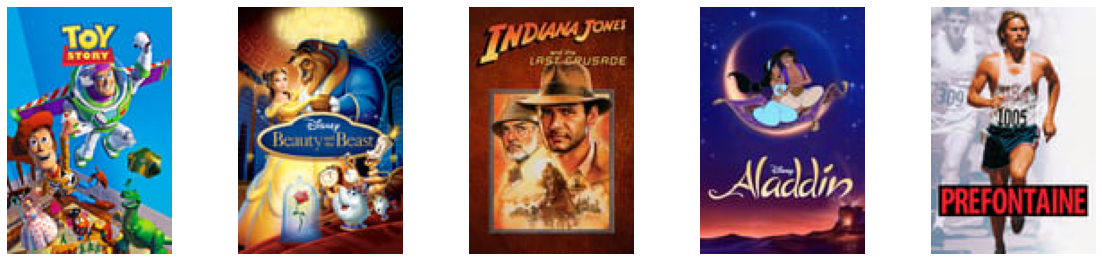

In [ ]:
show_similar(0, item_similar_indices, item_encoder) 